In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Aorta Dataset - Total NaNs after KNN imputation: 0
Brachial Dataset - Total NaNs after KNN imputation: 0


C:\Users\aman0\AppData\Local\Temp\ipykernel_3852\2340184544.py:56: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_aorta['moving_avg'] = df_aorta.rolling(window=window_size, axis=1).mean().mean(axis=1)
C:\Users\aman0\AppData\Local\Temp\ipykernel_3852\2340184544.py:57: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_brachial['moving_avg'] = df_brachial.rolling(window=window_size, axis=1).mean().mean(axis=1)
c:\Users\aman0\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy (XGBoost): 0.4857
Confusion Matrix (XGBoost):
[[88 19  7  4  0  0]
 [23 59 16 11  2  2]
 [ 9 17 44 26 15  3]
 [ 7  1 51 38 15 15]
 [ 0  3  6 27 43 33]
 [ 0  2  3 12 31 68]]


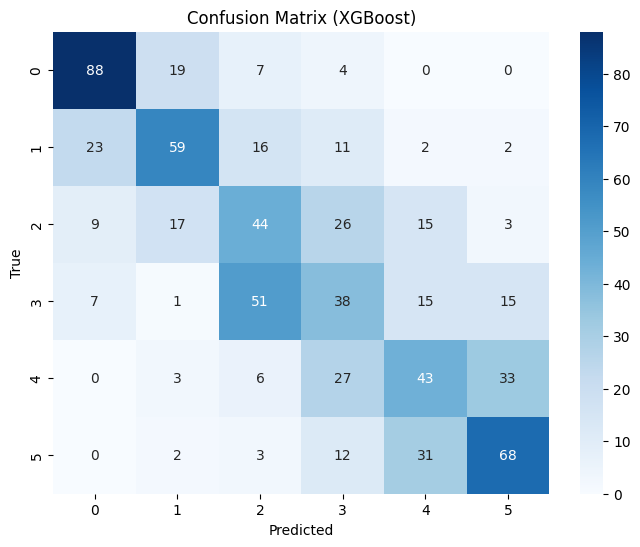

Aorta Test Dataset - Total NaNs after KNN imputation: 0
Brachial Test Dataset - Total NaNs after KNN imputation: 0
Predictions saved to 'xgboost_predictions.json'


C:\Users\aman0\AppData\Local\Temp\ipykernel_3852\2340184544.py:56: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_aorta['moving_avg'] = df_aorta.rolling(window=window_size, axis=1).mean().mean(axis=1)
C:\Users\aman0\AppData\Local\Temp\ipykernel_3852\2340184544.py:57: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df_brachial['moving_avg'] = df_brachial.rolling(window=window_size, axis=1).mean().mean(axis=1)


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np
import json
from matplotlib import pyplot as plt

# Read the datasets
aorta_df = pd.read_csv('aortaP_train_data.csv')
brachial_df = pd.read_csv('brachP_train_data.csv')
aorta_test_df = pd.read_csv('aortaP_test_data.csv')
brachial_test_df = pd.read_csv('brachP_test_data.csv')

# Preprocessing Functions (same as in your code)
def handle_nans_knn(df, dataset_name, n_neighbors=5):
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)
    nan_count_after = df_imputed.isna().sum().sum()
    print(f"{dataset_name} - Total NaNs after KNN imputation: {nan_count_after}")
    return df_imputed

def add_median_difference(df_aorta, df_brachial):
    aorta_medians = df_aorta.median(axis=1)
    brachial_medians = df_brachial.median(axis=1)
    median_difference = brachial_medians - aorta_medians
    df_aorta['median_difference'] = median_difference
    df_brachial['median_difference'] = median_difference
    return df_aorta, df_brachial

def add_pressure_std(df_aorta, df_brachial):
    df_aorta['pressure_std'] = df_aorta.std(axis=1)
    df_brachial['pressure_std'] = df_brachial.std(axis=1)
    return df_aorta, df_brachial

def add_max_min_pressure(df_aorta, df_brachial):
    df_aorta['max_pressure'] = df_aorta.max(axis=1)
    df_brachial['max_pressure'] = df_brachial.max(axis=1)
    df_aorta['min_pressure'] = df_aorta.min(axis=1)
    df_brachial['min_pressure'] = df_brachial.min(axis=1)
    return df_aorta, df_brachial

def add_pressure_ratio(df_aorta, df_brachial):
    df_aorta['pressure_ratio'] = df_brachial.mean(axis=1) / df_aorta.mean(axis=1)
    return df_aorta, df_brachial

def add_vascular_health_index(df_aorta, df_brachial):
    df_aorta['vascular_health_index'] = 0.5 * df_aorta['median_difference'] + 0.3 * df_aorta['pressure_std']
    df_brachial['vascular_health_index'] = 0.5 * df_brachial['median_difference'] + 0.3 * df_brachial['pressure_std']
    return df_aorta, df_brachial

def add_moving_average_pressure(df_aorta, df_brachial, window_size=3):
    df_aorta['moving_avg'] = df_aorta.rolling(window=window_size, axis=1).mean().mean(axis=1)
    df_brachial['moving_avg'] = df_brachial.rolling(window=window_size, axis=1).mean().mean(axis=1)
    return df_aorta, df_brachial

# Preprocess the training data
aorta_df = handle_nans_knn(aorta_df, 'Aorta Dataset')
brachial_df = handle_nans_knn(brachial_df, 'Brachial Dataset')

aorta_df, brachial_df = add_median_difference(aorta_df, brachial_df)
aorta_df, brachial_df = add_pressure_std(aorta_df, brachial_df)
aorta_df, brachial_df = add_max_min_pressure(aorta_df, brachial_df)
aorta_df, brachial_df = add_vascular_health_index(aorta_df, brachial_df)
aorta_df, brachial_df = add_pressure_ratio(aorta_df, brachial_df)
aorta_df, brachial_df = add_moving_average_pressure(aorta_df, brachial_df)

# Handle target column
if 'target' in aorta_df.columns:
    aorta_targets = aorta_df['target']
    aorta_df = aorta_df.drop(columns=['target'])

if 'target' in brachial_df.columns:
    brachial_targets = brachial_df['target']
    brachial_df = brachial_df.drop(columns=['target'])

# Normalize the datasets
aorta_scaler = StandardScaler()
brachial_scaler = StandardScaler()

aorta_normalized = aorta_scaler.fit_transform(aorta_df)
brachial_normalized = brachial_scaler.fit_transform(brachial_df)

# Split the training data into train and validation sets
X_train_aorta, X_val_aorta, X_train_brachial, X_val_brachial, y_train, y_val = train_test_split(
    aorta_normalized, brachial_normalized, aorta_targets, test_size=0.2, random_state=42)

# Flatten the features for XGBoost
X_train_aorta_flat = X_train_aorta.reshape(X_train_aorta.shape[0], -1)
X_train_brachial_flat = X_train_brachial.reshape(X_train_brachial.shape[0], -1)
X_val_aorta_flat = X_val_aorta.reshape(X_val_aorta.shape[0], -1)
X_val_brachial_flat = X_val_brachial.reshape(X_val_brachial.shape[0], -1)

# Combine the flattened data for XGBoost
X_train_combined = np.concatenate([X_train_aorta_flat, X_train_brachial_flat], axis=1)
X_val_combined = np.concatenate([X_val_aorta_flat, X_val_brachial_flat], axis=1)

# Train an XGBoost model
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgboost_model.fit(X_train_combined, y_train)

# Make predictions
y_val_pred = xgboost_model.predict(X_val_combined)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy (XGBoost): {val_accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Print confusion matrix
print("Confusion Matrix (XGBoost):")
print(cm)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val_pred), yticklabels=np.unique(y_val_pred))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# Preprocess the test data
aorta_test_df = handle_nans_knn(aorta_test_df, 'Aorta Test Dataset')
brachial_test_df = handle_nans_knn(brachial_test_df, 'Brachial Test Dataset')

aorta_test_df, brachial_test_df = add_median_difference(aorta_test_df, brachial_test_df)
aorta_test_df, brachial_test_df = add_pressure_std(aorta_test_df, brachial_test_df)
aorta_test_df, brachial_test_df = add_max_min_pressure(aorta_test_df, brachial_test_df)
aorta_test_df, brachial_test_df = add_vascular_health_index(aorta_test_df, brachial_test_df)
aorta_test_df, brachial_test_df = add_pressure_ratio(aorta_test_df, brachial_test_df)
aorta_test_df, brachial_test_df = add_moving_average_pressure(aorta_test_df, brachial_test_df)

# Normalize the test data
aorta_test_normalized = aorta_scaler.transform(aorta_test_df)
brachial_test_normalized = brachial_scaler.transform(brachial_test_df)

# Flatten the test features for XGBoost
X_test_aorta_flat = aorta_test_normalized.reshape(aorta_test_normalized.shape[0], -1)
X_test_brachial_flat = brachial_test_normalized.reshape(brachial_test_normalized.shape[0], -1)

# Combine the flattened test data
X_test_combined = np.concatenate([X_test_aorta_flat, X_test_brachial_flat], axis=1)

# Make predictions on the test set
test_predictions = xgboost_model.predict(X_test_combined)

In [10]:
# Save predictions to JSON
output_dict = {i : int(test_predictions[i]) for i in range(len(test_predictions))}

# Save the results in JSON format
with open('xgboost_predictions.json', 'w') as json_file:
    json.dump(output_dict, json_file)

print("Predictions saved to 'xgboost_predictions.json'")

Predictions saved to 'xgboost_predictions.json'
